# Loading the dataset and primitive operations
We shall use the [COCO dataset](http://cocodataset.org/#home) for object detection and retrieval for our projects. We shall supply suitable subsets of the dataset and feature representations for images.

### Necessary packages
Apart from standard packages numpy, matplotlib, PIL (Python Imaging Library) and cv2 (OpenCV for Python), we need the MS-COCO API. You can clone this [github repository](https://github.com/cocodataset/cocoapi) and follow instructions in the readme to install. Lastly, append the following line to your .bashrc file (assuming you use Linux/Mac):

`export PYTHONPATH="${PYTHONPATH}:/home/${path_to_coco_api}/cocoapi-master/PythonAPI"`

where `${path_to_coco_api}` is suitably substituted by the path to the cloned COCO API repository.
This allows you to use the following line to import the COCO API:

`from pycocotools.coco import COCO`

In [1]:
from __future__ import division
import os, sys, time, pickle
import itertools

%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8.0, 10.0)

import cv2
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('jpg')
from PIL import Image, ImageDraw

## Dataset description
Download the dataset in a directory, henceforth referred to as `dataDir`. The next cell below expects that directory structure for this demo. We supply the following for a small version of the dataset:
- train2014: training set of images for two supercategories for a total of 18 categories.
- val2014: validataion set of images for these supercategories and categories.
- annotations: annotations for the images with various objects in the images and their locations. COCO specifies the segmentation masks of each image, i.e., the location of the object is specified to the pixel level. We shall, however, only deal with tight rectangles around objects, also known as bounding boxes.
- features_tiny: for each training and validation images, this folder contains pickle dumps (Python objects stored on disk) of convolutional neural network features for these images. Each image is represented by $32\times 13 \times 13 \approx 5.5K$ features, so that all $n$ images are stored in a numpy array of size $n \times 32\times 13 \times 13$. These features have been supplied to debug your code on your laptops.
- features_small: for each training and validation images, this folder contains pickle dumps (Python objects stored on disk) of convolutional neural network features for these images. Each image is represented by $256 \times 13 \times 13 \approx 43K$ features, so that all $n$ images are stored in a numpy array of size $n \times 256\times 13 \times 13$. These are the features we shall use for our initial homeworks and as a small dataset for the project. Modern laptops should be able to handle this dataset with too much difficulty.

Notice that the features are stored as `np.float32`. It is recommended that you use only variables of type `float32` for efficiency reasons.

Later on, we shall supply a larger dataset that will require more compute power than standard laptops can handle.

In [2]:
# data and annotation directories
dataDir='/data' #### TODO: Ensure this is correct

# dataType='val2014' # uncomment to access the validation set
dataType='train2014' # uncomment to access the train set
# dataType='test2014' # uncomment to access the train set
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType) # annotations

# directory structure for this demo
print('Expected directory structure:')
print('-'*60)
for path, dirs, files in os.walk(dataDir):
    if path.split("/")[-1] != '.ipynb_checkpoints': 
        # do not disply jupyter related files
        print(path)
    if path.split("/")[-1] in ['features_small', 'features_tiny']:
        for f in files:
            print('-'*8, f)


Expected directory structure:
------------------------------------------------------------
/data
/data/train2014
/data/features_tiny
-------- train2014.p
-------- test2014.p
-------- val2014.p
/data/annotations
/data/features_small
-------- train2014.p
-------- test2014.p
-------- val2014.p


In [3]:
# initialize COCO api for instance annotations. This step takes several seconds each time.
coco=COCO(annFile)

loading annotations into memory...
Done (t=10.99s)
creating index...
index created!


### COCO categories and supercategories
We shall use the 'vehicle' and 'animal' supercategories and the categories therein for this part.

In [4]:
cats = coco.loadCats(coco.getCatIds()) # categories
cat_id_to_name = {cat['id']: cat['name'] for cat in cats} # category id to name mapping
cat_name_to_id = {cat['name']: cat['id'] for cat in cats} # category name to id mapping

cat_to_supercat = {cat['name']: cat['supercategory'] for cat in cats}
cat_id_to_supercat = {cat['id']: cat['supercategory'] for cat in cats}

# print supercategory and categories in each supercategory
supercat_to_cats = {}
for key, group in itertools.groupby(sorted([(sc, c) for (c, sc) in cat_to_supercat.items()]), lambda x: x[0]):
    lst = [thing[1] for thing in group]
    print(key, ":", '{1}{0}'.format("\n----".join(lst), "\n----"), '\n')
    supercat_to_cats[key] = lst

accessory : 
----backpack
----handbag
----suitcase
----tie
----umbrella 

animal : 
----bear
----bird
----cat
----cow
----dog
----elephant
----giraffe
----horse
----sheep
----zebra 

appliance : 
----microwave
----oven
----refrigerator
----sink
----toaster 

electronic : 
----cell phone
----keyboard
----laptop
----mouse
----remote
----tv 

food : 
----apple
----banana
----broccoli
----cake
----carrot
----donut
----hot dog
----orange
----pizza
----sandwich 

furniture : 
----bed
----chair
----couch
----dining table
----potted plant
----toilet 

indoor : 
----book
----clock
----hair drier
----scissors
----teddy bear
----toothbrush
----vase 

kitchen : 
----bottle
----bowl
----cup
----fork
----knife
----spoon
----wine glass 

outdoor : 
----bench
----fire hydrant
----parking meter
----stop sign
----traffic light 

person : 
----person 

sports : 
----baseball bat
----baseball glove
----frisbee
----kite
----skateboard
----skis
----snowboard
----sports ball
----surfboard
----tennis racket 


## Visualize images and bounding boxes

In [5]:
# good colormap
colors = [(30,144,255), (255, 140, 0), (34,139,34), (255,0,0), (147,112,219), (139,69,19), (255,20,147), (128,128,128),
         (85,107,47), (0,255,255)]
def get_color(i):
    return colors[i % len(colors)]

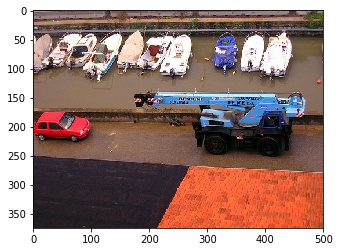

In [6]:
if dataType == 'train2014':
    i = 149331
elif dataType == 'val2014':
    i = 258789
else:
    i = 193972

img = coco.loadImgs([i])[0]
img_pil = Image.open('%s/%s/%s'%(dataDir, dataType, img['file_name'])) # make sure data dir is correct
plt.imshow(img_pil)

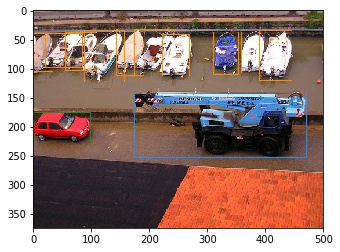

In [7]:
# load annotations for this image
annIds = coco.getAnnIds(imgIds=img['id'],  iscrowd=None)
anns = coco.loadAnns(annIds)

categories = {j:i for (i,j) in dict(enumerate(set([ann['category_id'] for ann in anns]))).items()}

img_pil = Image.open('%s/%s/%s'%(dataDir, dataType, img['file_name'])) # make sure data dir is correct
draw = ImageDraw.Draw(img_pil)

for ann in anns:
    x, y, w, h = ann['bbox']
    cat_color_id = categories[ann['category_id']] # to give each category a different color
    draw.rectangle(((x, y, x+w, y+h)), fill=None, outline=get_color(cat_color_id)) #RGB
plt.imshow(img_pil)

## Load extacted features:
The demo shows how to extract and use the tiny features. The procedure to use small features is identical.

In [8]:
t1 = time.time()
with open(os.path.join(dataDir, 'features_tiny', '{}.p'.format(dataType)), 'rb') as f:
    [img_list, feats] = pickle.load(f, encoding="bytes")
print('time to load features =', time.time() - t1, 'sec')
print('num images =', len(img_list))
print('shape of features =', feats.shape)

time to load features = 0.8489518165588379 sec
num images = 2000
shape of features = (2000, 32, 13, 13)


Here, `img_id` is list of image ids where `feats[i, :, :, :]` are features corresponding to image `img_id[i]`.

## Find supercategories associated with each image

In [9]:
img_id = img_list[0] # any image ID to find supercategory
annIds = coco.getAnnIds(imgIds=img['id'],  iscrowd=None)
anns = coco.loadAnns(annIds)

categories = set([ann['category_id'] for ann in anns])
supercategories = set([cat_id_to_supercat[ann['category_id']] for ann in anns ])
print(supercategories) # expect singleton

{'vehicle'}
